In [28]:
from datasets import load_dataset
import datasets
from collections import Counter
import re
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import torch
import matplotlib.pyplot as plt

In [4]:
# 加载 IMDB 数据集
cache_dir=r'D:\code_file\dl_Practical_operation\data_file'
imdb_dataset = load_dataset("imdb",cache_dir=cache_dir)
# .map(): 对所有样本应用一个函数 (非常重要，用于预处理):

In [7]:
# 查看数据集结构
# 深拷贝复制数据
paragraphs=[i for i in imdb_dataset['unsupervised']['text']]
# 整个文本——段落——句子
paragraphs_sentence=[paragraph.split('.') for paragraph in paragraphs ]

In [8]:
def tokenize(content):
    tokenized_content=[]
    for paragraph_lines in content:
        tokenize_list=[i.replace('<br />','').lower().split() for i in paragraph_lines]
        tokenized_content.append(tokenize_list)
    return tokenized_content

def flatten_list(lst):
    for i in lst:
        if isinstance(i,list):
            yield from flatten_list(i)
        else:
            yield i
            
class Vocab:
    def __init__(self,token_list,min_freq=5,reserved_tokens=None):
        """传入的词表可以是嵌套列表"""
        token_freq=Counter(flatten_list(token_list))
        self._token_freq=[]
        self._reserved_tokens=[] if reserved_tokens is None else reserved_tokens
        if '<unk>' not in self._reserved_tokens:
            self._reserved_tokens=['<unk>']+self._reserved_tokens
            
        # 每个词的词频 然后过滤掉词频不足的词
        for item in sorted(token_freq.items(),key=lambda x:x[1],reverse=True):
            if item[1]<min_freq:
                break
            self._token_freq.append(item)

        # idx_to_token 和 token_to_idx
        self.id2token=self._reserved_tokens+[i[0] for i in self._token_freq]
        self.token2idx={}
        for num,token in enumerate(self.id2token):
            self.token2idx[token]=num
    
    def to_idx(self,token):
        default=self.token2idx['<unk>']
        return self.token2idx.get(token,default)
    
    def __getitem__(self, idx):
        return self.id2token[idx]
    
    def __len__(self):
        return len(self.id2token)
    
    @property
    def token_freq(self):
        return self._token_freq
    
paragraph_tokenize=tokenize(paragraphs_sentence)

In [11]:
v=Vocab(paragraph_tokenize)

In [26]:
lens_list=[]
for paragraph in paragraph_tokenize:
    for sentence in paragraph:
        lens_list.append(len(sentence))

In [30]:
lens_hist=Counter(lens_list)

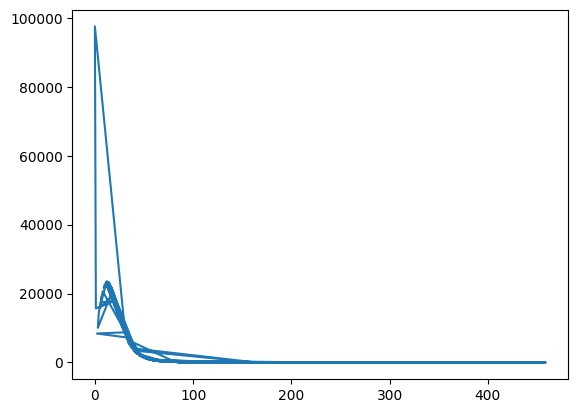

In [34]:
plt.plot(lens_hist.keys(),lens_hist.values())

In [153]:
import math
# 从0实现一个Encoderblock
#1、点积注意力
class DotProductAttention(nn.Module):
    def __init__(self, dropout=0.1,**kwargs):
        super(DotProductAttention, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
    def forward(self, q, k, v, valid_lens=None):
        #q.shape[-1]是静态维度值（整数）将其包装为张量是冗余操作
        # d_lens=torch.tensor(q.shape[-1],device=q.device)
        d_lens=q.shape[-1]
        #对于标量值，PyTorch会自动处理设备兼容性 所以不用显示todevice
        attention_scores=torch.matmul(q,k.transpose(-1,-2)) / math.sqrt(d_lens)
        self.attention_weights=masked_softmax(attention_scores, valid_lens)
        return torch.matmul(self.dropout(self.attention_weights),v)

class MultiHeadAttention(nn.Module):
    def __init__(self,key_size,query_size,value_size,hidden_size,num_heads,dropout=0.1,bias=False,**kwargs):
        super(MultiHeadAttention, self).__init__(**kwargs)
        assert hidden_size%num_heads==0,'整除条件不满足！'
        # 三个调整size的 全连接
        # 易错点 这里的全连接层都是没有偏置项 因为后续会有layer_normal 即使添加偏置项后续也会在减均值的过程中被吸收掉
        #         一个更广义的规则：
        # 如果一个线性层（或卷积层）的输出紧接着一个归一化层（Batch Norm, Layer Norm, Instance Norm, Group Norm），那么这个线性层/卷积层中的偏置项就是冗余的，通常会将其设置为 False。
        self.W_q=nn.Linear(query_size,hidden_size,bias=bias)
        self.W_k=nn.Linear(key_size,hidden_size,bias=bias)
        self.W_v=nn.Linear(value_size,hidden_size,bias=bias)
        # 最终输出用的全连接
        self.W_o=nn.Linear(hidden_size,hidden_size,bias=bias)
        # 注意力函数
        self.attention=DotProductAttention(dropout=dropout)
        # 头数
        self.num_heads=num_heads
        # 隐藏层数
        self.hidden_size=hidden_size


    def forward(self,q,k,v,valid_lens=None):
        #调整qkv最后一层
        # reshape出头数 并放在第二各维度 避免影响遮掩的softmax
        # 错了一个地方 self.hidden_size/self.num_heads结果默认是浮点即使结果是整数 reshape无法接受浮点 因此要用//
        # q_temp=self.W_q(q).reshape(q.shape[0],q.shape[1],self.num_heads,self.hidden_size/self.num_heads).permute(0,2,1,3)
        q_temp=self.W_q(q).reshape(q.shape[0],q.shape[1],self.num_heads,self.hidden_size//self.num_heads).permute(0,2,1,3)
        k_temp=self.W_k(k).reshape(k.shape[0],k.shape[1],self.num_heads,self.hidden_size//self.num_heads).permute(0,2,1,3)
        v_temp=self.W_v(v).reshape(v.shape[0],v.shape[1],self.num_heads,self.hidden_size//self.num_heads).permute(0,2,1,3)

        # 转为三维 将 1 2维度合并
        q_temp=q_temp.reshape(-1,q.shape[1],self.hidden_size//self.num_heads)
        k_temp=k_temp.reshape(-1,k.shape[1],self.hidden_size//self.num_heads)
        v_temp=v_temp.reshape(-1,v.shape[1],self.hidden_size//self.num_heads)

        if valid_lens is not None:
        # 这里很重要有一个知识点 看上面 其实是在batch_size 后增加了一个维度num_head 然后又reshape成batch_size*num_heads
        # 这跟torch和numpy的存储方式有关系 contiguous (行主序)  当然也正是这种存储方式才使得我们要把num_heads 挪到第二维
        # 由于每一个batch下增加的多个num_heads 其实都是归属在这个样本下的不同的注意力头的结果 对于这个样本其实他的valid_lens是不变的 也需要重复num_heads次
        # 所以对于valid_lens 最简单的做法就是复制num_head次就行 所以使用repeat_interleave
        # 当valid_lens 为2d明显要在batch_size维度进行复制，dim=0
        # 当valid_lens为1维时，维度大小=batch_size 这跟我们实现的masked_softmax函数有关 显然也是在batch_size维度复制 所以无论valid_lens为多少维度 都是在dim=0维复制
            valid_lens=valid_lens.repeat_interleave(self.num_heads,dim=0)


        attention_result_total=self.attention(q_temp,k_temp,v_temp,valid_lens)
        outputs=attention_result_total.reshape(q.shape[0],self.num_heads,q.shape[1],-1).permute(0,2,1,3).reshape(q.shape[0],q.shape[1],-1)
        return self.W_o(outputs)

class PositionalEncoding(nn.Module):
    def __init__(self,max_len,hidden_size,dropout=0.1,**kwargs):
        super(PositionalEncoding, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
        self.P=torch.zeros(1,max_len,hidden_size)
        # 易错点这里建议不用除法， 直接 ：：2 否则少一个
        self.temp=torch.arange(1,max_len+1).unsqueeze(1)/(torch.pow(10000,torch.arange(0,hidden_size,2)/hidden_size))
        #1,2 用 1位置  如果一共只有3个 那就是 只有
        self.P[:,:,0::2]=torch.sin(self.temp)
        self.P[:,:,1::2]=torch.cos(self.temp)

    def forward(self,x):
        # 注意p和x在第二个维度不一定一样,device也不一定一样
        x = x + self.P[:,:x.shape[1],:].to(x.device)
        return self.dropout(x)

class AddNorm(nn.Module):
    def __init__(self,norm_shape,dropout=0.1,**kwargs):
        super(AddNorm, self).__init__(**kwargs)
        self.norm=nn.LayerNorm(norm_shape)
        self.dropout = nn.Dropout(dropout)
    def forward(self,x,y):
        return self.norm(x+self.dropout(y))

class PositionWiseFFN(nn.Module):
    def __init__(self,ffninput_size,ffnhidden_size,ffnoutput_size,**kwargs):
        super(PositionWiseFFN, self).__init__(**kwargs)
        self.dense1 = nn.Linear(ffninput_size,ffnhidden_size)
        self.relu=nn.ReLU()
        self.dense2=nn.Linear(ffnhidden_size,ffnoutput_size)
    def forward(self,x):
        x_temp = self.relu(self.dense1(x))
        return self.dense2(x_temp)

class EncoderBlock(nn.Module):
    def __init__(self,key_size,query_size,value_size,hidden_size,num_heads,norm_shape,ffninput_size,ffnhidden_size,dropout=0.1,bias=False,**kwargs):
        super(EncoderBlock, self).__init__(**kwargs)
        # 位置编码 max=1000 hidden_size 和query的size一样 不是在块里完成的
        # self.position_enc = PositionalEncoding(1000,query_size,dropout=dropout)
        # 多头自注意力key_size,query_size,value_size,hidden_size这四个应该是全都相等
        self.attention=MultiHeadAttention(key_size,query_size,value_size,hidden_size,num_heads,dropout=dropout,bias=bias)
        #位置前馈 ffninput_size=ffnoutput_size=hidden_size
        self.position_ffn=PositionWiseFFN(ffninput_size,ffnhidden_size,hidden_size,**kwargs)
        # norm_shape = (l,hidden_size)
        self.add_norm=AddNorm(norm_shape,dropout=dropout)

    def forward(self,x_position,valid_lens=None):
        y_attention=self.attention(x_position,x_position,x_position,valid_lens=valid_lens)
        x_first=self.add_norm(x_position,y_attention)
        return self.add_norm(x_first,self.position_ffn(x_first))


In [ ]:
class TransformerEncoderClassfier(nn.Module):
    def __init__(self):